In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import csv
import os
import glob
import numpy as np

import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras import Input

from PIL import Image as img
import matplotlib.pyplot as plt

map = {'normal': 0, 'mipatients': 1, 'abnormalhb': 2, 'historymi':3}



In [ ]:
tr_x=[]
tr_y=[]
ls =['normal', 'mipatients', 'abnormalhb', 'historymi']
#path = os.getcwd()
path = "/content/gdrive/MyDrive/gridRemoval"
i=0
for y in os.listdir(path):
    all_files = glob.glob(path + "/"+y +"/*.*")
    for filename in all_files:
        tr_x.append(filename)
        tr_y.append(y)

In [ ]:

#(256,149)
target_size = (400,232)
#target_size = (224,224)
def plot_image(image_path):
    # Load image using Pillow
    image = img.open(image_path).convert('RGB')
    resized_image = image.resize(target_size)
    # Convert image to numpy array
    image_data = np.array(resized_image)
    return image_data


In [ ]:
X=[]
Y=[]
for i in tr_x:
    X.append(plot_image(i))

for i in tr_y:
    Y.append(map[i])

In [ ]:
#len(Y)
#ny = np.array(Y)
X[0][0][0]

array([0, 0, 0], dtype=uint8)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=41)

In [ ]:
X_train = np.stack(X_train, axis=0)

In [ ]:
print("X_train shape:", X_train.shape)  # Expected to be (num_samples, 512, 297, 3)
#print("y_train shape:", y_train.shape)  # Expected to be (num_samples, num_classes) for one-hot encoded labels


X_train shape: (2088, 232, 400, 3)


In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)  # Adjust 'num_classes' as per your dataset


In [ ]:
X_test = np.stack(X_test, axis=0)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load ResNet50 with pre-trained ImageNet weights, without the top layer
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(232,400, 3))

# Freeze the base model layers
for layer in base_resnet.layers:
    layer.trainable = False

# Add new layers on top for your dataset
x = base_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # New FC layer, you can change the number of units
predictions = Dense(4, activation='softmax')(x)  # New output layer

# Define the new model
resnet = Model(inputs=base_resnet.input, outputs=predictions)

# Compile the model
resnet.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Preprocess input
X_train_preprocessed = preprocess_input(np.array(X_train, dtype=np.float32))

resnet.summary()

94765736/94765736 [==============================] - 3s 0us/step


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 232, 400, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 238, 406, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 116, 200, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 116, 200, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
X_train_preprocessed = preprocess_input(np.array(X_train, dtype=np.float32))
history = resnet.fit(X_train_preprocessed, y_train, epochs=50, validation_split=0.1)

Epoch 1/50
59/59 [==============================] - 30s 346ms/step - loss: 1.1982 - accuracy: 0.6285 - val_loss: 0.6977 - val_accuracy: 0.7416
Epoch 2/50
59/59 [==============================] - 11s 191ms/step - loss: 0.6372 - accuracy: 0.7493 - val_loss: 0.6226 - val_accuracy: 0.7416
Epoch 3/50
59/59 [==============================] - 11s 192ms/step - loss: 0.5150 - accuracy: 0.8137 - val_loss: 0.5993 - val_accuracy: 0.7847
Epoch 4/50
59/59 [==============================] - 11s 194ms/step - loss: 0.5221 - accuracy: 0.8026 - val_loss: 0.5261 - val_accuracy: 0.8038
Epoch 5/50
59/59 [==============================] - 11s 195ms/step - loss: 0.4494 - accuracy: 0.8366 - val_loss: 0.4462 - val_accuracy: 0.8373
Epoch 6/50
59/59 [==============================] - 12s 198ms/step - loss: 0.3974 - accuracy: 0.8505 - val_loss: 0.5748 - val_accuracy: 0.8325
Epoch 7/50
59/59 [==============================] - 12s 202ms/step - loss: 0.3923 - accuracy: 0.8574 - val_loss: 0.5091 - val_accuracy: 0.8325

In [ ]:
# Preprocess the test images
X_test_preprocessed = preprocess_input(np.array(X_test, dtype=np.float32))
#y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes=4)

# Evaluate the model on the test set
test_loss, test_accuracy = resnet.evaluate(X_test_preprocessed, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


17/17 [==============================] - 5s 280ms/step - loss: 0.4015 - accuracy: 0.9023
Test Loss: 0.4015272557735443
Test Accuracy: 0.9022988677024841


17/17 [==============================] - 4s 175ms/step


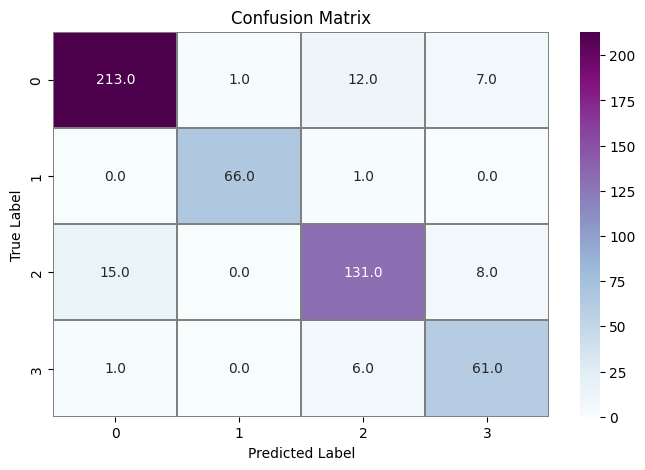

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       233
           1       0.99      0.99      0.99        67
           2       0.87      0.85      0.86       154
           3       0.80      0.90      0.85        68

    accuracy                           0.90       522
   macro avg       0.90      0.91      0.90       522
weighted avg       0.90      0.90      0.90       522



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = resnet.predict(X_test_preprocessed)
Y_pred_classes = np.argmax(Y_pred,axis=1)
Y_true = np.argmax(y_test,axis=1)

report = classification_report(Y_true, Y_pred_classes)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Print classification report
print("Classification Report:")
print(report)

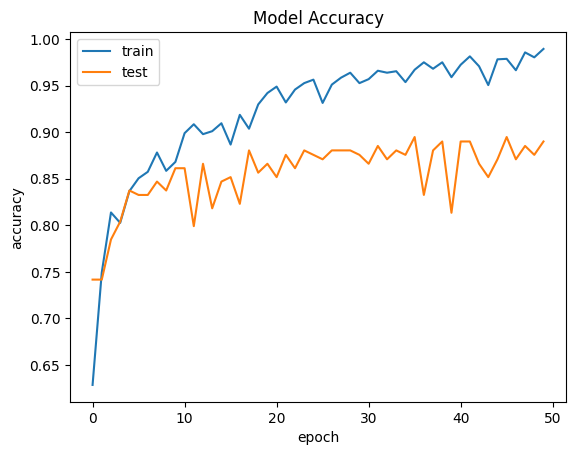

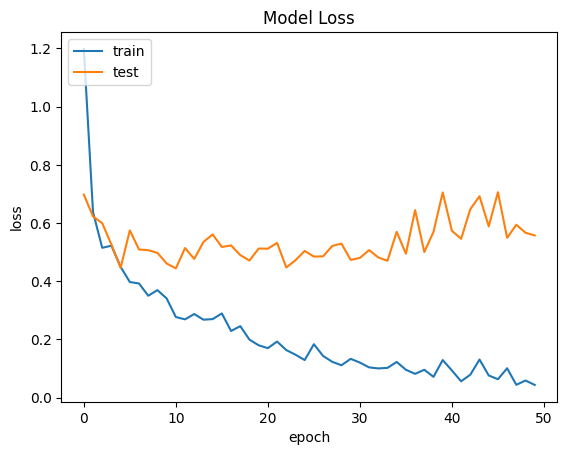

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()